<a href="https://colab.research.google.com/github/twisha-k/Python_notes/blob/main/134_coding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lesson 134: Movie Recommender II - Weighted Rating

---

### Teacher-Student Activities

In the previous class, we built a simple recommender system which recommended movies on the basis of popularity.

In this class we will build a custom recommendation engine which recommends movies based on:

1. Top rated movies (as per weighted rating algorithm).

2. Top rated movies for each movie genre.

In the upcoming classes, we will build few basic recommendation systems. Let us first explore the dataset used for building this recommender.


---

#### Movie Recommender Problem Statement

**The Dataset**

The movies dataset contains metadata for 45,000 movies released on or before July 2017 and listed in the [MovieLens](https://movielens.org) database. Features include genre, title, budget, revenue, release dates, languages, production countries and companies, countries, [TMDB](https://www.themoviedb.org) vote counts and vote averages, and other details. Below are the features information:

**Attribute Information:**

    adult: Indicates if the movie is X-Rated or Adult.
    belongs_to_collection: A stringified dictionary that gives information on the movie series the particular film belongs to.
    budget: The budget of the movie in dollars.
    genres: A stringified list of dictionaries that list out all the genres associated with the movie.
    homepage: The Official Homepage of the move.
    id: The ID of the movie.
    imdb_id: The IMDB ID of the movie.
    original_language: The language in which the movie was originally shot in.
    original_title: The original title of the movie.
    overview: A brief blurb of the movie.
    popularity: The Popularity Score assigned by TMDB.
    poster_path: The URL of the poster image.
    production_companies: A stringified list of production companies involved with the making of the movie.
    production_countries: A stringified list of countries where the movie was shot/produced in.
    release_date: Theatrical Release Date of the movie.
    revenue: The total revenue of the movie in dollars.
    runtime: The runtime of the movie in minutes.
    spoken_languages: A stringified list of spoken languages in the film.
    status: The status of the movie (Released, To Be Released, Announced, etc.)
    tagline: The tagline of the movie.
    title: The Official Title of the movie.
    video: Indicates if there is a video present of the movie with TMDB.
    vote_average: The average rating of the movie.
    vote_count: The number of votes by users, as counted by TMDB.

<br>

**Problem Statement**

Imagine you are working as a Data Scientist for Netflix or a similar movie streaming platform. Your company wants to catch on to the new subscribers by making them hooked to their multimedia content. As a Data Scientist you are expected to construct an algorithm to recommend movie to newly registered users. For this:

- You need to find out the most important features in the dataset to build a recommender system to suggest top movies for new subscribers.

- As new subscribers do not have a watch history, your task is to identify and suggest top rated movies which a new user is likely to appreciate and as a result stay connected to the streaming platform.

**Acknowledgement:** This dataset is an ensemble created by Rounak Banik using the data collected from TMDB and GroupLens.

**Dataset Source:** https://www.kaggle.com/rounakbanik/the-movies-dataset

---

#### Recap

Let's import the necessary Python modules.

Also, read the data from a csv file to create a Pandas DataFrame and go through the necessary data-cleaning process (if required).

**Dataset Link:** https://drive.google.com/uc?id=1rPR-P45M2UWsbXc8vpyCzWcQAYUfgVJX

Our aim is to build three simple recommender systems which recommends:
1. Top 20 movies having highest popularity.
2. Top 20 movies having highest average weighted rating.
3. Top 20 movies of a genre having highest rating.

As our dataset contains a lot of features that are not useful in building the above recommenders, let us create a subset of this dataset that consists of important features like:

`genres`, `id`, `popularity`, `title`, `vote_average`, `vote_counts`


In [ ]:
# Import the required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Read the dataset and print first five records.
url = "https://drive.google.com/uc?id=1rPR-P45M2UWsbXc8vpyCzWcQAYUfgVJX"
movies_df = pd.read_csv(url)

# Create a DataFrame with only required features.

mov_subset_df = movies_df[['genres', 'id', 'popularity', 'title', 'vote_average', 'vote_count']]

Let us now proceed with data cleaning and data preparation for subset DataFrame.




---



#### Data Cleaning

While making recommendation it is important to check for any duplicate entry for a movie in the database. Since 2 movies might have same name but the `id` would be different for them, check and remove for duplicate entries on `id` field.


In [ ]:
# Drop the duplicate rows on id column
mov_subset_df = mov_subset_df.drop_duplicates(subset = ['id'])

Let's drop the null values from the dataset.

The data type of `id` and `popularity` column must be `int` and `float` respectively. Let's convert the data type of these columns using `astype()` function.

In [ ]:
# Drop null values from the subset DataFrame
mov_subset_df.dropna(inplace = True)

# Convert the type of 'id' column to 'int' type.
mov_subset_df['id'] = mov_subset_df['id'].astype('int')

# Convert the type of 'popularity' column to 'float' type.
mov_subset_df['popularity'] = mov_subset_df['popularity'].astype('float')

To make movie recommendation and to identify top movies in each genre, we need to convert the `genres` field to a list which contains only the names of genres the movie fall into.

For example, the first row of this dataset would look like this:

`[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]`

$$\boldsymbol{\big\Downarrow}$$

<center>

`[Animation, Comedy, Family]` </center>


Although we can do this by accessing the genre `name` from the respective list of dictionaries and appending them to a list. However, we will use two new methods to achieve this: **Lambda Function** and **literal_eval() Function**.

Let us now understand them in more detail.



In [ ]:
# Use lambda function and 'literal_eval()' to obtain a list of genres.

from ast import literal_eval
mov_subset_df['genres'] = mov_subset_df['genres'].apply(lambda x: [i['name'] for i in literal_eval(x)])

The `genres` column is now modified and comprises of list of the genres the respective movie falls into.

Our dataset is now ready for building some recommendation systems.

Before building some recommenders, let us obtain one more subset of the dataset where the `genres` field would contain only a  single value rather than a list.






---



#### Exploding DataFrame

We can notice that the elements in the `'genres'` column of the subset DataFrame consist of lists. However, we may need to expand the list into multiple columns to keep only a single genre rather than a list of genres in each row.

For example:

<center>
<img src="https://s3-whjr-v2-prod-bucket.whjr.online/whjr-v2-prod-bucket/1e1742f6-98c1-4dc6-851a-988662d1706f.PNG"/>

The genres list can be expanded like this:


<img src="https://s3-whjr-v2-prod-bucket.whjr.online/whjr-v2-prod-bucket/f5d115a0-94d2-44cc-a1c5-473efaac92b6.PNG"/></center>

To unpack or expand the list of genres, use `explode()` function of pandas DataFrame. This function transforms each element of a list-like to a row. It returns DataFrame exploded lists to rows of the subset columns.

**Syntax of `explode()` function:** `DataFrame.explode(column, ignore_index = False)`

Here,
 - `column`:  Column to be exploded.
 - `ignore_index`: bool, default `False`. If `True`, the resulting index will be labelled `0, 1,..., n - 1`.

Let us now explode the `genres` column. If we want to assign a new index number to every row of the DataFrame, just use `ignore_index = True` parameter.

In [ ]:
# Explode 'genres' column and give new index to every row.
genres_subset_df = mov_subset_df.explode('genres', ignore_index = True)

We now obtained a subset DataFrame where  `genres` field now consists of a single element.  We can use this subset DataFrame for performing various data visualisation that we will perform in the next class.  

Let us now build a simple movie recommender that recommends movies on the basis of the popularity score.


---

#### Recommendation on the basis of Popularity

Let us now recommend top 20 popular movies to the new subscriber by simply sorting the subset DataFrame by `'popularity'` column.

In [ ]:
# Top 20 movies as per popularity of the movie
top_20_popular = mov_subset_df.sort_values(by = 'popularity', ascending = False).head(20)
top_20_popular

,genres,id,popularity,title,vote_average,vote_count
30700,"[Family, Animation, Adventure, Comedy]",211672,547.488298,Minions,6.4,4729.0
33356,"[Action, Adventure, Fantasy]",297762,294.337037,Wonder Woman,7.2,5025.0
42222,"[Family, Fantasy, Romance]",321612,287.253654,Beauty and the Beast,6.8,5530.0
43644,"[Action, Crime]",339403,228.032744,Baby Driver,7.2,2083.0
24455,"[Adventure, Family, Animation, Action, Comedy]",177572,213.849907,Big Hero 6,7.8,6289.0
26564,"[Action, Adventure, Comedy]",293660,187.860492,Deadpool,7.4,11444.0
26566,"[Action, Adventure, Comedy, Science Fiction]",283995,185.330992,Guardians of the Galaxy Vol. 2,7.6,4858.0
14551,"[Action, Adventure, Fantasy, Science Fiction]",19995,185.070892,Avatar,7.2,12114.0
24351,"[Action, Thriller]",245891,183.870374,John Wick,7.0,5499.0
23675,"[Mystery, Thriller, Drama]",210577,154.801009,Gone Girl,7.9,6023.0


Thus the most popular movie across all genres is **Minions**. This list of movies is like YouTube trending page and can be recommended to a new subscriber.

Let us also visualise this DataFrame by creating a barplot using `seaborn` module. Plot `'popularity'` on $x$-axis and `'title'` on $x$-axis.


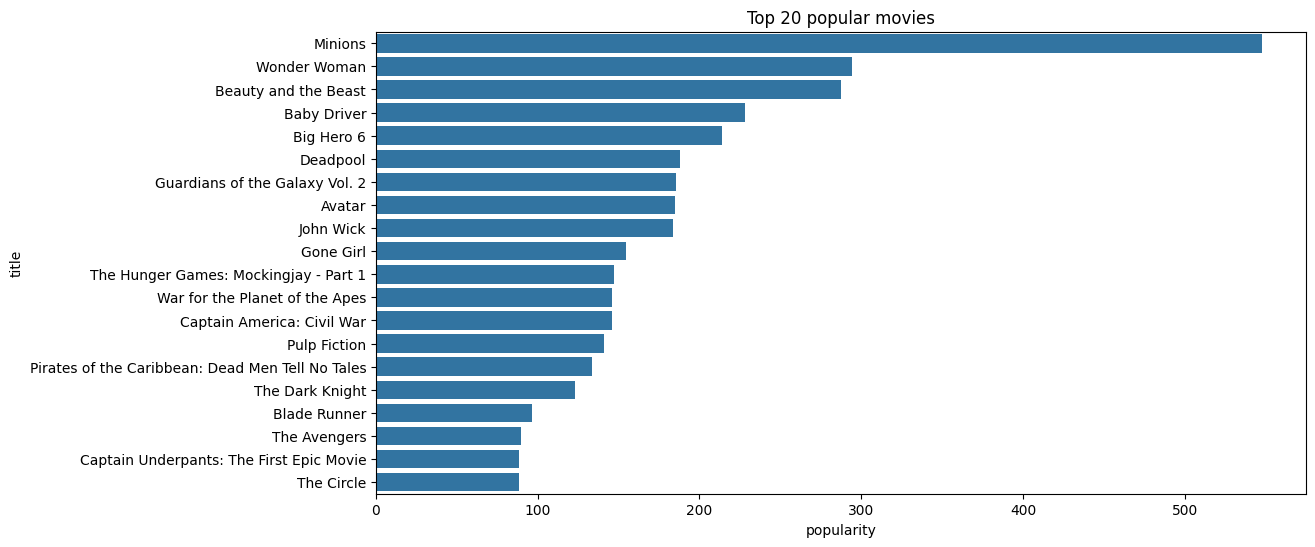

In [ ]:
# Plot top 20 popular movies
plt.figure(figsize = (12, 6))
sns.barplot(x='popularity', y= 'title', data = top_20_popular)
plt.title("Top 20 popular movies")
plt.show()

Hence, a new subscriber can be recommended with these popular movies. This was a recommender system on the basis of popularity score by TMDB.



---

#### Activity 1: Genre Based Movie Distribution

In the previous class, we obtained a DataFrame where the `genres` field consists of only a single genre rather than a list of genres. Let us now analyse this DataFrame in more detail to provide genre-specific recommendations.

Before that, let us check the number of record and null values in the `genres_subset_df` DataFrame.




In [ ]:
# S1.1: Print the number of records and percentage of null values in the 'genres_subset_df' DataFrame
genres_subset_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93448 entries, 0 to 93447
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   genres        91006 non-null  object 
 1   id            93448 non-null  int64  
 2   popularity    93448 non-null  float64
 3   title         93448 non-null  object 
 4   vote_average  93448 non-null  float64
 5   vote_count    93448 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 4.3+ MB


In [ ]:
genres_subset_df['genres'].isnull().sum()*100/len(genres_subset_df)

2.613218046400137

Here we observe that there are 2442 movies for which no genre information has been specified. Let's drop these movies from the DataFrame as these null records are only about $2.6\%$ of the total listed movies in the dataset.

In [ ]:
# S1.2: Drop the movies with null genres
genres_subset_df.dropna(inplace=True)
genres_subset_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91006 entries, 0 to 93445
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   genres        91006 non-null  object 
 1   id            91006 non-null  int64  
 2   popularity    91006 non-null  float64
 3   title         91006 non-null  object 
 4   vote_average  91006 non-null  float64
 5   vote_count    91006 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 4.9+ MB


Next, count the number of movies in each genre using `value_counts()` function.



In [ ]:
# S1.3: Obtain the count of movies falling into each genre
genres_count=genres_subset_df['genres'].value_counts()
genres_count

Drama              20243
Comedy             13176
Thriller            7618
Romance             6730
Action              6590
Horror              4670
Crime               4304
Documentary         3930
Adventure           3490
Science Fiction     3042
Family              2767
Mystery             2464
Fantasy             2309
Animation           1930
Foreign             1619
Music               1597
History             1398
War                 1322
Western             1042
TV Movie             765
Name: genres, dtype: int64

Here we observe that the genre `Drama` has highest number of movies, followed by `Comedy` and so on. We can also visualise this genre distribution by creating a barplot using `seaborn` module.

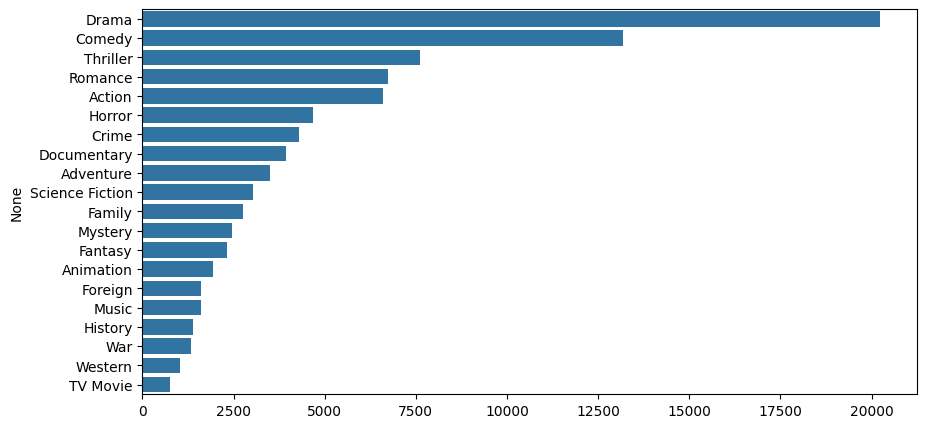

In [ ]:
# S1.4: Create a barplot with number of movies in each genre on x-axis and genre names on y-axis.
plt.figure(figsize=(10,5))
sns.barplot(x=genres_count.values,y=genres_count.index)
plt.show()

From the above graph it is clear that top 5 genres consisting of largest number of movies are:

1. Drama
2. Comedy
3. Thriller
4. Romance
5. Action

However, this does not imply that these 5 genres are the most popular or highly rated genres.

Let us find out which genres are most popular or possess good ratings among the users.


---

#### Activity 2: Analysing Genre Based Popularity

Viewer's opinion can be obtained by analysing the following features of the dataset:

`popularity`, `vote_average`, and `vote_count`

Let us obtain the mean values of `popularity`, `vote_average`, and `vote_count` for all genres by creating a pivot table as follows:

1. Create a new DataFrame that consists of only following columns from the genres subset DataFrame:
 - `genres`
 - `popularity`
 - `vote_average`
 - `vote_count`

2. Use `pivot_table()` function of `pandas` module and pass the above newly created DataFrame and `index = ['genres']` as inputs. This will display the mean values of `popularity`, `vote_average`, and `vote_count` columns for each `genres`.

3. Use `reset_index()` function to reset the index of the resulting DataFrame and display the resulting DataFrame.

In [ ]:
# T2.1: Create a pivot table to determine the total count of parameters

# Create a new DataFrame with 'genres', popularity', 'vote_average' and 'vote_count' columns
parameter_df=genres_subset_df[['genres', 'popularity', 'vote_average','vote_count']]

# Create a pivot table with index = ['genres']
genre_table=pd.pivot_table(data=parameter_df,index="genres").reset_index()
genre_table

,genres,popularity,vote_average,vote_count
0,Action,4.773008,5.584932,259.232777
1,Adventure,6.001218,5.687593,410.936390
2,Animation,4.709924,6.275544,234.534715
3,Comedy,3.230777,5.715642,109.106937
4,Crime,4.142982,5.877649,176.028346
5,Documentary,0.948341,5.823028,12.836641
6,Drama,3.010777,5.905888,96.570074
7,Family,4.728138,5.753632,242.281171
8,Fantasy,5.366410,5.790775,333.171503
9,Foreign,0.761960,5.735639,7.984558


Thus, the above DataFrame exhibits the average `popularity`, `vote_average`, and `vote_count` for each genre.

Let us visualise which `genres` have highest mean popularity score by creating a barplot with mean `popularity` scores arranged in descending order on $x$-axis and `genres` on $y$-axis.



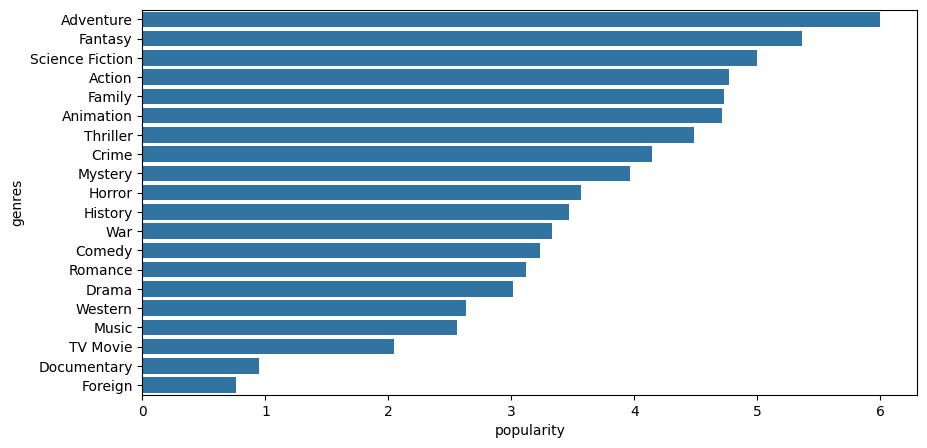

In [ ]:
# S2.1: Plot average popularity score arranged in descending order vs genres
plt.figure(figsize=(10,5))
sns.barplot(x='popularity',y='genres',data=genre_table.sort_values(by='popularity',ascending=False))
plt.show()

Thus, according to mean popularity score, the top 5 most popular genres are:
1. Adventure
2. Fantasy
3. Science Fiction
4. Action
5. Family

Hence, for new users, we can suggest movies from these genres, as the user is most likely to appreciate these recommendations.

Similarly, let us visualise which `genres` has  the highest `vote_count` by creating a barplot with mean `vote_count` scores arranged in descending order on $x$-axis and `genres` on $y$-axis.



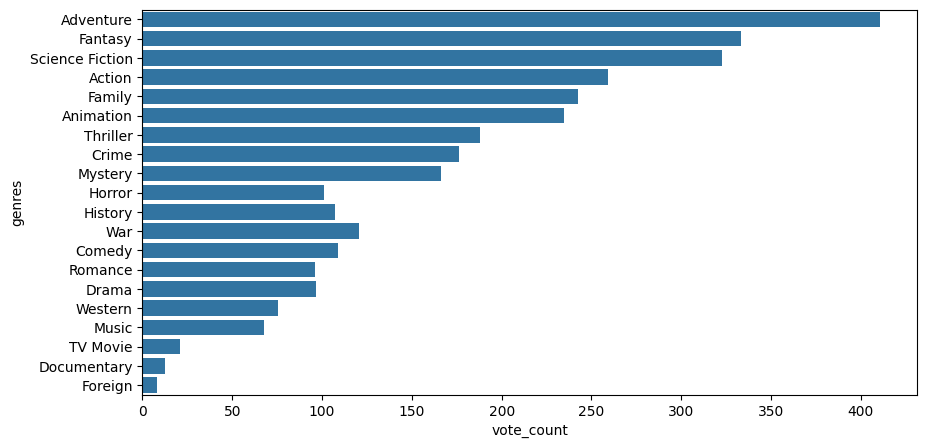

In [ ]:
# S2.2: Plot average  `vote_count` arranged in descending order vs genres
plt.figure(figsize=(10,5))
sns.barplot(x='vote_count',y='genres',data=genre_table.sort_values(by='popularity',ascending=False))
plt.show()

Thus, according to mean vote counts, the top 5 most voted genres are:

1. Adventure
2. Fantasy
3. Science Fiction
4. Action
5. Family

Similarly, let us visualise which `genres` has  the highest `vote_average` by creating a barplot with mean `vote_average` scores arranged in descending order on $x$-axis and `genres` on $y$-axis.



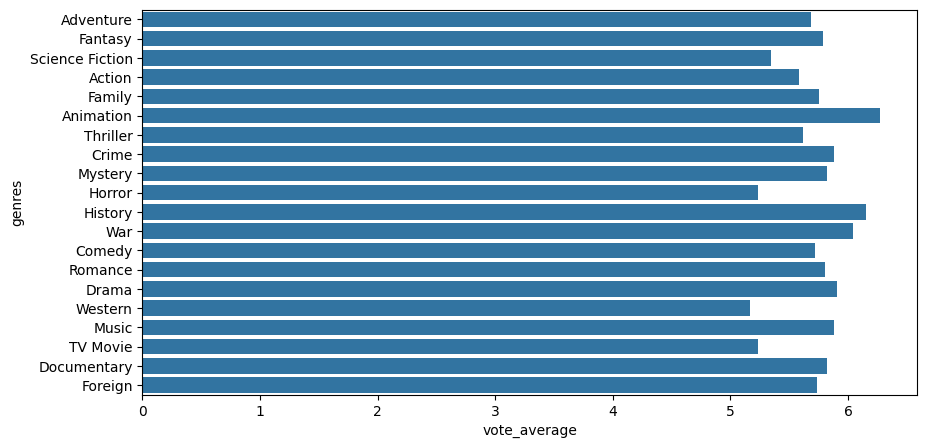

In [ ]:
# S2.3: Plot mean `'vote_average` arranged in descending order vs genres
plt.figure(figsize=(10,5))
sns.barplot(x='vote_average',y='genres',data=genre_table.sort_values(by='popularity',ascending=False))
plt.show()

Thus, according to mean vote average, the top 5 genres with highest average rating are:

1. Animation
2. History
3. War
4. Drama
5. Music

Now that we have analysed different genres based on their popularity score, vote counts and average rating, let us now build some more simple movie recommenders.

---

#### Activity 3: Recommendation Based on Ratings

In the previous lesson, we recommended top 20 movies based on their `popularity` score. We can also recommend movies to a new subscriber on the basis of their average ratings (`'vote_average'`).

Let us now recommend top 20 highly rated movies to the new subscriber by simply sorting the subset movie DataFrame by `'vote_average'` column.

In [ ]:
# S3.1: Recommend top 20 movies as per average rating of the movie
top20=genres_subset_df.sort_values(by='vote_average',ascending=False).head(20)
top20


,genres,id,popularity,title,vote_average,vote_count
44566,Drama,148408,0.036880,The Crush,10.0,1.0
82861,Action,84275,0.124803,The Dragon Lives Again,10.0,1.0
48246,Comedy,157862,0.853913,Growing Pains,10.0,1.0
83014,Comedy,86360,0.401213,Sunnyside Up,10.0,1.0
82909,Drama,407298,0.111670,American Hostage,10.0,1.0
54652,Documentary,248870,0.610441,An Apology to Elephants,10.0,1.0
82908,Crime,407298,0.111670,American Hostage,10.0,1.0
82907,Thriller,407298,0.111670,American Hostage,10.0,1.0
82860,Fantasy,84275,0.124803,The Dragon Lives Again,10.0,1.0
47079,Comedy,71508,0.329193,The Taming of the Shrew,10.0,1.0


From the above results, you may observe that many of the highest rated movies (`vote_average = 10.0`) has `vote_count = 1.0`. This means that the rating `10` was given by only 1 subscriber to these movies.

Hence, we cannot proclaim these movies as highest rated movies as the rating was given by very few subscribers. Thus, we cannot recommend movies to a new subscriber by simply considering `vote_average` column.

In other words, using a simple average rating as a metric has following limitations:

1. It does not take into consideration the popularity of a movie. A movie with a rating of 9 from 20 voters will be considered *better* than a movie with a rating of 8 from 10,000 voters.

2. On a related note, this metric will favour movies with a smaller number of voters with skewed or extremely high ratings.

Hence, it is difficult to distinguish the quality of a movie with extremely few voters. To overcome these shortcomings, we have to consider both average rating and the number of voters. For this we will use the  weighted rating formula used by IMDB.


##### **Weighted Average Rating:**

Let us use the weighted average rating formula to recommend top rated movies to the user. This technique is employed by IMDB to determine its top movies chart.

The weighted rating approach ensures that a film with only a few ratings, all at 10, would not rank above "the Godfather", for example, with a 9.2 average from over 500,000 ratings. It is mathematically represented as:

\begin{align}
\text{W} = \frac{Rv + Cm }{v + m}
\end{align}

Where,
  - $W$ is the Weighted Rating.
  - $R$ is the average rating of the movie.
  - $v$ is the number of votes for the movie.
  - $m$ is the minimum votes required to be listed in the top movies list.
  - $C$ denotes the mean vote across the whole dataset.

**Source:**  http://trailerpark.weebly.com/imdb-rating.html?source=post_page



We already have the values of $v$ (`vote_count`) and $R$ (`vote_average`) for each movie in the dataset.

Let's calculate the value of C, the mean rating across all movies using the pandas `mean()` function:


**Note:** Make sure to use the `mov_subset_df` DataFrame for recommendation as the `genres_subset_df` DataFrame has duplicate entries of movies based on genre list.

In [ ]:
# S3.2: Calculate mean of 'vote_average' column
mov_subset_df['vote_average'].mean()

5.618329297820823

From the above output, you can observe that the average rating of a movie is around 5.6 on a scale of 10.

Lastly, we need to calculate $m$ i.e. the minimum votes required to be listed in the top movies list.

**Determining $m$:**

There is no fixed value of $m$ and you can choose it accordingly. You can consider it as a filter that will simply remove the movies that have a number of votes less than a certain threshold $m$.

For our recommender, we will use cutoff $m$ as the 90th percentile. A 90% quantile means that in order to assign weighted rating to a movie, it must have more than 90% votes.

Let's calculate the minimum number of votes $m$ in the 90th percentile by using `quantile()` function of pandas.



In [ ]:
# T3.1: Determine the minimum number of votes for a movie in order to qualify it for recommendation
mov_subset_df['vote_count'].quantile(0.9)

160.0

This means any movie which has received less than 160 votes will not be considered for weighted rating and hence will not be recommended at all.

Since now we have the $m$, let us simply filter the movies whose `vote_count` is greater than or equal to `160` using the steps given below:

1. Use `DataFrame.copy()` function to create a copy of the original movie subset DataFrame followed by `DataFrame.loc[]` function to filter movies.

2. Specify the following condition inside the `loc[]` function to obtain only those movies whose `vote_count` is greater than or equal to `m`:

  `mov_subset_df['vote_count'] >= m`



In [ ]:
# T3.2: Create a DataFrame of movies having vote_count more than minimum number of votes
c=mov_subset_df['vote_average'].mean()
m=mov_subset_df['vote_count'].quantile(0.9)
qualified_movies_df = mov_subset_df.copy().loc[mov_subset_df['vote_count'] >= m]
qualified_movies_df.head()

,genres,id,popularity,title,vote_average,vote_count
0,"[Animation, Comedy, Family]",862,21.946943,Toy Story,7.7,5415.0
1,"[Adventure, Fantasy, Family]",8844,17.015539,Jumanji,6.9,2413.0
4,[Comedy],11862,8.387519,Father of the Bride Part II,5.7,173.0
5,"[Action, Crime, Drama, Thriller]",949,17.924927,Heat,7.7,1886.0
8,"[Action, Adventure, Thriller]",9091,5.231580,Sudden Death,5.5,174.0


Thus, the `qualified_movies_df` DataFrame consists of all the movies which have received more than the minimum number of votes.

Now, final step is to  calculate the weighted rating for each qualified movie. To do this, we will:

Define a function `weighted_rating` and pass the corresponding DataFrame as input. Inside this function:

 1. Determine $v$ using the `vote_count` column of the DataFrame.
 2. Determine $R$ using the `vote_average` column of the DataFrame.

 3. Calculate the weighted average $W$  using the formula and return the calculated weighted rating.

In [ ]:
# S3.4: Function to computes the weighted rating of each movie
def weighted_rating(df):
  v=df['vote_count']
  r=df['vote_average']
  w=( (r*v)+(c*m)/(v+m) )
  return w



The above function will calculate the weighted rating for each qualified movie. Let us add this weighted rating as a separate column to the qualified movies DataFrame using the steps given below:


1. Use `DataFrame.apply()` function and pass the above `weighted_rating` function as input to the `apply()` function. This will invoke the `weighted_rating()` function for each qualified movies.

2. Set `axis = 1` as we want to apply the `weighted_rating` function to each row of the DataFrame.

3. Finally, display the first 5 values of the resulting DataFrame.

In [ ]:
# T3.3: Append a column for the weighted rating of the movies in the DataFrame
mov_subset_df['vote_average'].mean()
qualified_movies_df['weighted_rating']=qualified_movies_df.apply(weighted_rating,axis=1)
qualified_movies_df.head()

,genres,id,popularity,title,vote_average,vote_count,weighted_rating
0,"[Animation, Comedy, Family]",862,21.946943,Toy Story,7.7,5415.0,41695.661244
1,"[Adventure, Fantasy, Family]",8844,17.015539,Jumanji,6.9,2413.0,16650.049371
4,[Comedy],11862,8.387519,Father of the Bride Part II,5.7,173.0,988.799498
5,"[Action, Crime, Drama, Thriller]",949,17.924927,Heat,7.7,1886.0,14522.639361
8,"[Action, Adventure, Thriller]",9091,5.231580,Sudden Death,5.5,174.0,959.691415


Now, let's display the top 25 movies of all time (irrespective of genre).

<center><img src=https://s3-whjr-v2-prod-bucket.whjr.online/whjr-v2-prod-bucket/0912101f-2c0b-4d23-939d-33202e2a763d.jpg width=400>

`Photo by Towfiqu barbhuiya from Pexels`</center>


To display the top 25 highly rated movies:

1. Sort the qualified movies DataFrame based on `weighted_rating` column in descending order.

2. Display the first 25 entries of the sorted DataFrame.

In [ ]:
# S3.4: Display the top 25 movies.
top25=qualified_movies_df.sort_values(by="weighted_rating",ascending=False).head(25)
top25

,genres,id,popularity,title,vote_average,vote_count,weighted_rating
15480,"[Action, Thriller, Science Fiction, Mystery, A...",27205,29.108149,Inception,8.1,14075.0,114007.563149
12481,"[Drama, Action, Crime, Thriller]",155,123.167259,The Dark Knight,8.3,12269.0,101832.772325
22879,"[Adventure, Drama, Science Fiction]",157336,32.213481,Interstellar,8.1,11187.0,90614.779222
17818,"[Science Fiction, Action, Adventure]",24428,89.887648,The Avengers,7.4,12000.0,88800.073925
14551,"[Action, Adventure, Fantasy, Science Fiction]",19995,185.070892,Avatar,7.2,12114.0,87220.873239
26564,"[Action, Adventure, Comedy]",293660,187.860492,Deadpool,7.4,11444.0,84685.677467
2843,[Drama],550,63.869599,Fight Club,8.3,9678.0,80327.491374
20051,"[Drama, Western]",68718,19.785025,Django Unchained,7.8,10297.0,80316.685965
23753,"[Action, Science Fiction, Adventure]",118340,53.291601,Guardians of the Galaxy,7.9,10014.0,79110.688356
292,"[Thriller, Crime]",680,140.950236,Pulp Fiction,8.3,8670.0,71961.101804


Here we see that the movies are now ranked based on the weighted rating assigned to them. These ratings are more reliable and hence, we can recommend movies to the new subscriber based on these weighted ratings.

Next we will tweak the recommendation engine to get recommendations based on genre.

---

#### Activity 4: Genre - Specific Recommendation

As everybody has a preferred genre, sometimes the user might want to navigate to a particular genre and get recommendation based on the selected genre. Hence, let's tweak the recommendation engine to recommend movie based on selected genre.

For this, first explode the `genres` column of qualified movies DataFrame to get a single genre instead of a list of genres using the `explode()` function.

In [ ]:
# S4.1: Create a genre based DataFrame for qualified movies to get a single genre in 'genres' column
gen_data=qualified_movies_df.explode('genres',ignore_index=True)
gen_data

,genres,id,popularity,title,vote_average,vote_count,weighted_rating
0,Animation,862,21.946943,Toy Story,7.7,5415.0,41695.661244
1,Comedy,862,21.946943,Toy Story,7.7,5415.0,41695.661244
2,Family,862,21.946943,Toy Story,7.7,5415.0,41695.661244
3,Adventure,8844,17.015539,Jumanji,6.9,2413.0,16650.049371
4,Fantasy,8844,17.015539,Jumanji,6.9,2413.0,16650.049371
...,...,...,...,...,...,...,...
11994,Action,417320,15.842073,Descendants 2,7.5,171.0,1285.215809
11995,Comedy,417320,15.842073,Descendants 2,7.5,171.0,1285.215809
11996,Music,417320,15.842073,Descendants 2,7.5,171.0,1285.215809
11997,Adventure,417320,15.842073,Descendants 2,7.5,171.0,1285.215809


We now have a DataFrame which consists of single genre of the movies along with the obtained weighted rating.

To recommend movies to a user based on his/her selected or preferred genre, let's build a user-defined function that accepts a genre as input and returns a DataFrame consisting of top 25 highest weighted rating movies belonging to that genre.

To build a genre based movie recommender:

- Declare a function `genre_recommender()` that accepts `fav_genre` as input. In this function:

 1. Create a DataFrame `recommended_df` that will be returned by this function.

 2. Filter the movies based on the selected `genre` by passing the following condition inside the genre based DataFrame:

   `genre_based_df['genres'] == fav_genre`
  
 3. Return the top 25 entries from `recommended_df` DataFrame.

In [ ]:
# T4.1: Declare the genre based recommender function
def genre_recommender(fav_genre):
  recommended_df = gen_data[gen_data['genres'] == fav_genre]
  return(recommended_df.head(25))

Let's test the function by getting recommendation for `Thriller` movies. For this, invoke the `genre_recommender()` function and pass `'Thriller'` as the input to this function to get recommendation of Thriller movies.

In [ ]:
# S4.2: Recommend 'Thriller' movies
genre_recommender('Thriller')


,genres,id,popularity,title,vote_average,vote_count,weighted_rating
10,Thriller,949,17.924927,Heat,7.7,1886.0,14522.639361
13,Thriller,9091,5.231580,Sudden Death,5.5,174.0,959.691415
16,Thriller,710,14.686036,GoldenEye,6.6,1194.0,7881.063909
38,Thriller,8012,12.669608,Get Shorty,6.4,305.0,1953.933189
41,Thriller,1710,10.701801,Copycat,6.5,199.0,1296.003991
45,Thriller,9691,11.065939,Assassins,6.0,394.0,2365.622622
54,Thriller,63,12.297305,Twelve Monkeys,7.4,2470.0,18278.341800
69,Thriller,577,10.448481,To Die For,6.7,177.0,1188.567456
72,Thriller,807,18.457430,Se7en,8.1,5915.0,47911.647972
79,Thriller,629,16.302466,The Usual Suspects,8.1,3334.0,27005.657279


Here, we obtained top 25 thriller movies having highest weighted rating.

Next, let's get recommendation on `'Horror'` movies.

In [ ]:
# S4.3: Recommend 'Horror' movies
genre_recommender('Horror')

,genres,id,popularity,title,vote_average,vote_count,weighted_rating
21,Horror,12110,5.430331,Dracula: Dead and Loving It,5.7,210.0,1199.429548
85,Horror,755,15.339153,From Dusk Till Dawn,6.9,1644.0,11344.098300
172,Horror,9348,13.492845,Species,5.5,457.0,2514.956941
212,Horror,628,11.970205,Interview with the Vampire,7.2,1558.0,11218.123244
233,Horror,3036,14.287753,Mary Shelley's Frankenstein,6.1,272.0,1661.280863
283,Horror,12122,6.529879,Village of the Damned,5.6,165.0,926.765947
321,Horror,11596,9.860522,New Nightmare,6.4,297.0,1902.767030
359,Horror,2654,8.497643,In the Mouth of Madness,7.1,307.0,2181.624909
579,Horror,9100,12.860385,The Craft,6.3,388.0,2446.040388
632,Horror,10779,12.090960,The Frighteners,6.7,413.0,2768.668818


Here, we obtained top 25 horror movies having highest weighted rating.

Next, let's get recommendation on `'Drama'` movies.

In [ ]:
# S4.4: Recommend 'Drama' movies
genre_recommender('Drama')

,genres,id,popularity,title,vote_average,vote_count,weighted_rating
9,Drama,949,17.924927,Heat,7.7,1886.0,14522.639361
18,Drama,9087,6.318445,The American President,6.5,199.0,1296.003991
25,Drama,524,10.137389,Casino,7.8,1343.0,10475.998092
27,Drama,4584,10.673167,Sense and Sensibility,7.2,364.0,2622.515520
40,Drama,1710,10.701801,Copycat,6.5,199.0,1296.003991
46,Drama,451,10.332025,Leaving Las Vegas,7.1,365.0,2593.212253
51,Drama,9909,9.481338,Dangerous Minds,6.4,249.0,1595.797879
57,Drama,9598,14.404764,Babe,6.0,756.0,4536.981368
60,Drama,687,6.891317,Dead Man Walking,7.3,350.0,2556.762613
62,Drama,9603,9.882383,Clueless,6.9,828.0,5714.109851


Now we have top recommendation on drama movies.

Similarly you can test recommendation on '`Adventure'` movies.

In [ ]:
# S4.5: Recommend 'Adventure' movies
genre_recommender('Adventure')

,genres,id,popularity,title,vote_average,vote_count,weighted_rating
3,Adventure,8844,17.015539,Jumanji,6.9,2413.0,16650.049371
12,Adventure,9091,5.231580,Sudden Death,5.5,174.0,959.691415
14,Adventure,710,14.686036,GoldenEye,6.6,1194.0,7881.063909
24,Adventure,21032,12.140733,Balto,7.1,423.0,3004.841909
33,Adventure,9273,8.205448,Ace Ventura: When Nature Calls,6.1,1128.0,6881.497929
43,Adventure,9691,11.065939,Assassins,6.0,394.0,2365.622622
50,Adventure,902,9.822423,The City of Lost Children,7.6,308.0,2342.720796
73,Adventure,10530,13.280069,Pocahontas,6.7,1509.0,10110.838606
93,Adventure,9208,14.957626,Broken Arrow,5.7,459.0,2617.752234
133,Adventure,10329,7.260574,Congo,5.0,214.0,1072.403563


Here we observe that the system has correctly recommended top movies in the adventure genre. Hence, we have successfully designed the basic recommendation engine for our new users.



**Note:**

1. The accuracy of this type of recommendation engine totally depends on the accuracy of the movie description in the dataset. If a movie is incorrectly classified in a genre, the system will still recommend the movie based on viewer's votes.

2. This kind of system is suitable for new users but will not be a good recommendation engine for the users having sufficient watch history. Since, based on a user's watch history, more engaging movies can be recommended.

3. Majority of popular movie rating websites used some kind of modified version of the weighted rating technique for rating the movies on their respective platform/websites.

<br>

Let's stop here. In the next class, we will implement collaborative filters to make movie recommendation based on user's watch history.

---